In [17]:
import pandas as pd
import os

# df = pd.read_csv('C:/Cand.merc.BI/2. Semester/Data Science Project/Project/BilbasenProject/data/data_analysis/engineered_data_ID_4_pre_split.csv')
df = pd.read_csv('C:/Simon/Projekter/Data Science Project/BilbasenProject/data/data_analysis/engineered_data_ID_4_pre_split.csv')

In [18]:
df = df.drop(columns=['Unnamed: 0'])

Convert object to category

In [19]:
df['Acceleration_category'] = pd.Categorical(df['Acceleration_category'], categories=['fast', 'medium', 'slow'], ordered=True)
df['Range_category'] = pd.Categorical(df['Range_category'], categories=['short', 'medium', 'long'], ordered=True)
df['Color'] = pd.Categorical(df['Color'])

In [20]:
df['Acceleration_category'].dtypes.ordered

True

In [21]:
df['Range_category'].dtypes.ordered

True

In [22]:
df['Color'].dtypes.ordered

False

In [23]:
df

,Link,Dealer/private,Price_kr,Mileage_km,Color,AWD/RWD,Age_in_months,Acceleration_category,Range_category
0,https://www.bilbasen.dk/brugt/bil/vw/id4/pro-p...,True,299800,2000,Grey,False,33,medium,medium
1,https://www.bilbasen.dk/brugt/bil/vw/id4/pro-p...,True,329800,5000,Blue,False,19,medium,medium
2,https://www.bilbasen.dk/brugt/bil/vw/id4/pro-5...,True,289900,7000,White,False,10,slow,long
3,https://www.bilbasen.dk/brugt/bil/vw/id4/gtx-4...,True,419800,50,White,True,14,fast,short
4,https://www.bilbasen.dk/brugt/bil/vw/id4/gtx-4...,True,359900,37,Silver,True,11,fast,medium
...,...,...,...,...,...,...,...,...,...
481,https://www.bilbasen.dk/brugt/bil/vw/id4/pro-p...,False,339000,15000,Black,False,18,medium,medium
482,https://www.bilbasen.dk/brugt/bil/vw/id4/gtx-4...,False,350000,8000,White,True,15,fast,medium
483,https://www.bilbasen.dk/brugt/bil/vw/id4/pro-p...,False,295000,25000,Silver,False,17,medium,medium
484,https://www.bilbasen.dk/brugt/bil/vw/id4/pro-p...,False,299500,42000,Grey,False,37,medium,medium


In [24]:
df = df.drop(columns=['Color'])

In [25]:
import numpy as np
df['Mileage_km'] = np.sqrt(df['Mileage_km'])
df['Age_in_months'] = np.sqrt(df['Age_in_months'])

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.15, random_state=100)

Just checking the distributions of train and test

array([[<Axes: title={'center': 'Price_kr'}>,
        <Axes: title={'center': 'Mileage_km'}>],
       [<Axes: title={'center': 'Age_in_months'}>, <Axes: >]],
      dtype=object)

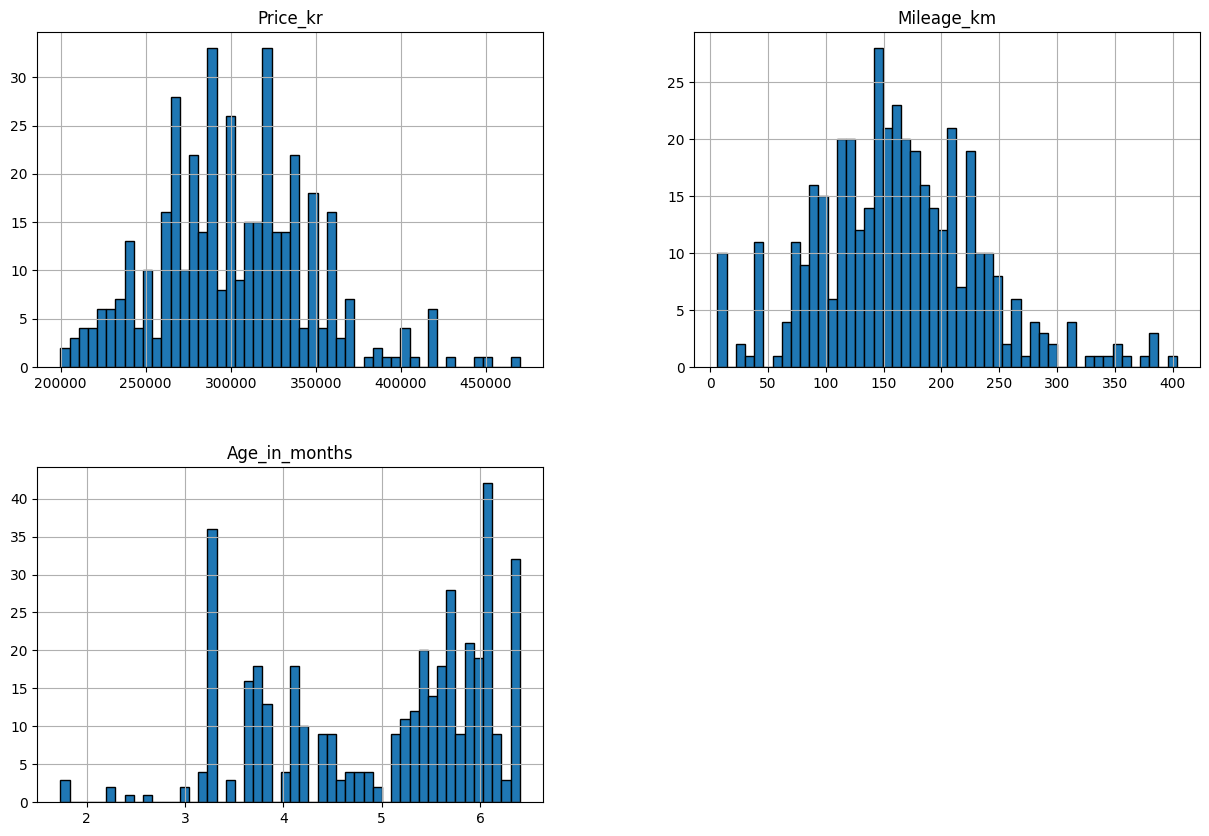

In [27]:
train_df.hist(bins=50, edgecolor='black', figsize=(15, 10))

array([[<Axes: title={'center': 'Price_kr'}>,
        <Axes: title={'center': 'Mileage_km'}>],
       [<Axes: title={'center': 'Age_in_months'}>, <Axes: >]],
      dtype=object)

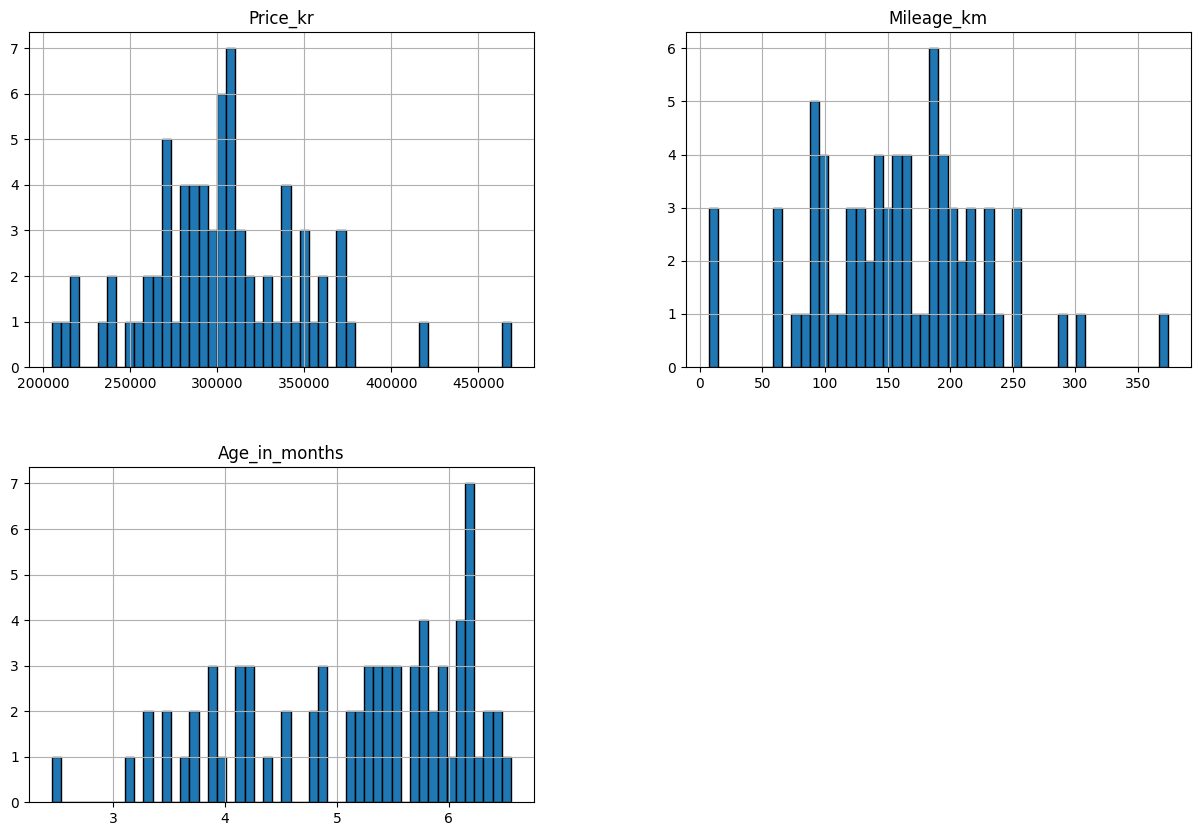

In [28]:
test_df.hist(bins=50, edgecolor='black', figsize=(15, 10))

Preparing for the models on training and testing

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Extract Features and Target from train_df
X_train = train_df.drop(columns=['Price_kr', 'Link'])
y_train = train_df['Price_kr']

# Convert categorical features to dummy variables
X_train = pd.get_dummies(X_train, drop_first=True)

# Ensure the test set has the same dummy variables as the training set
X_test = test_df.drop(columns=['Price_kr', 'Link'])
X_test = pd.get_dummies(X_test, drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

y_test = test_df['Price_kr']

Creating the models

In [34]:
#Paramgrid for tuning models

#For Random forest
param_grid_RF = {
    'n_estimators': [50, 100, 150],
    'max_depth': [20, 30, 50],  # Reasonable depth options
    'min_samples_split': [10, 15, 20],  # Balanced range for min_samples_split
    'min_samples_leaf': [4, 6, 8],  # Balanced range for min_samples_leaf
    'max_features': ['sqrt', 'log2'],  # Focused options
    'bootstrap': [True]  # Commonly used bootstrap setting
}


#For Gradiant boosting
param_grid_GB = {
    'n_estimators': [150, 200, 250],  # Focused range of trees
    'learning_rate': [0.01, 0.05, 0.1],  # Balanced learning rates
    'max_depth': [5, 7, 10],  # Reasonable depth options
    'min_samples_split': [10, 15, 20],  # Balanced range for min_samples_split
    'min_samples_leaf': [4, 6, 8],  # Balanced range for min_samples_leaf
    'max_features': ['sqrt', 'log2'],  # Focused options
    'subsample': [0.8, 0.9]  # Commonly used subsampling settings
}

param_grid_KNN = {
    'n_neighbors': [20, 22, 25, 27, 30, 35],  # Increase number of neighbors
    'weights': ['uniform', 'distance'],  # Include both weighting functions
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Stick to simpler distance metrics
}

param_grid_SVR = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['rbf'],
    'gamma': ['scale']
}


In [35]:
#Grid searching

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR


#For Random forest
grid_search_RF = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_RF,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Perform Grid Search
grid_search_RF.fit(X_train, y_train)

# Get the best parameters
best_params_RF = grid_search_RF.best_params_
print("Best parameters found for RF: ", best_params_RF)


# For gradiant boosting
grid_search_GB = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid_GB,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Perform Grid Search
grid_search_GB.fit(X_train, y_train)

# Get the best parameters
best_params_GB = grid_search_GB.best_params_
print("Best parameters found for GB: ", best_params_GB)


# Grid search for KNN
grid_search_KNN = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=param_grid_KNN,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)
# Perform Grid Search
grid_search_KNN.fit(X_train, y_train)

best_params_KNN = grid_search_KNN.best_params_
print("Best parameters found for KNN: ", best_params_KNN)


# Grid search for SVR
grid_search_SVR = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid_SVR,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)
# Perform Grid Search
grid_search_SVR.fit(X_train, y_train)

best_params_SVR = grid_search_SVR.best_params_
print("Best parameters found for SVR: ", best_params_SVR)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters found for RF:  {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 150}
Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best parameters found for GB:  {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 20, 'n_estimators': 150, 'subsample': 0.9}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found for KNN:  {'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters found for SVR:  {'C': 10, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}


In [36]:
#Train the linear regression Model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

#Linear model
model_train_LM = LinearRegression()
model_train_LM.fit(X_train, y_train)

#KNN model
model_train_KNN = KNeighborsRegressor(**best_params_KNN)
model_train_KNN.fit(X_train, y_train)

#Random Forest model
model_train_RF = RandomForestRegressor(**best_params_RF, random_state=42)
model_train_RF.fit(X_train, y_train)

#Gradient Boosting Regressor model
model_train_GBR = GradientBoostingRegressor(**best_params_GB, random_state=42)
model_train_GBR.fit(X_train, y_train)

# Instantiate and train the SVR model
model_train_SVR = SVR(**best_params_SVR)
model_train_SVR.fit(X_train, y_train)


SVR(C=10, epsilon=0.01)

In [37]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Function to evaluate a model and return the metrics
def evaluate_model(model, X_train, y_train, X_test, y_test):
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    mse_train = mean_squared_error(y_train, train_predictions)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, train_predictions)
    
    mse_test = mean_squared_error(y_test, test_predictions)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, test_predictions)
    
    return mse_train, rmse_train, r2_train, mse_test, rmse_test, r2_test

# List of models to evaluate
models = {
    'Linear Regression': model_train_LM,
    'KNN': model_train_KNN,
    'Random Forest': model_train_RF,
    'Gradient Boosting': model_train_GBR,
    'SVR': model_train_SVR
}

# Create a list to store the results
results = []

# Evaluate each model and store the results in the list
for model_name, model in models.items():
    mse_train, rmse_train, r2_train, mse_test, rmse_test, r2_test = evaluate_model(model, X_train, y_train, X_test, y_test)
    results.append({
        'Model': model_name, 
        'MSE_Train': mse_train, 
        'RMSE_Train': rmse_train, 
        'R2_Train': r2_train,
        'MSE_Test': mse_test, 
        'RMSE_Test': rmse_test, 
        'R2_Test': r2_test
    })

# Convert the list of results into a DataFrame
results_df = pd.DataFrame(results)

results_df


,Model,MSE_Train,RMSE_Train,R2_Train,MSE_Test,RMSE_Test,R2_Test
0,Linear Regression,5.278401e+08,22974.771685,0.746556,5.459319e+08,23365.184631,0.739464
1,KNN,1.677981e+07,4096.316309,0.991943,1.281172e+09,35793.469233,0.388585
2,Random Forest,4.286744e+08,20704.454560,0.794171,4.969344e+08,22292.025972,0.762847
3,Gradient Boosting,3.203356e+08,17897.923056,0.846190,4.773769e+08,21848.957404,0.772181
4,SVR,2.078193e+09,45587.198881,0.002151,2.099274e+09,45817.837161,-0.001839


Using the Linear Model

In [38]:
y_test

272    289900
332    309900
468    214900
98     299000
437    359800
        ...  
152    317000
412    234900
330    339900
154    349700
62     468800
Name: Price_kr, Length: 73, dtype: int64

In [39]:
y_test = pd.DataFrame(y_test)

In [40]:
y_test['LM_predictions'] = model_train_LM.predict(X_test)

In [41]:
y_test['prediction_difference'] = y_test['Price_kr'] - y_test['LM_predictions']

In [42]:
y_test['%_diff_from_LM'] = y_test['prediction_difference']/y_test['LM_predictions']

In [43]:
y_test

,Price_kr,LM_predictions,prediction_difference,%_diff_from_LM
272,289900,261754.907643,28145.092357,0.107525
332,309900,328132.733637,-18232.733637,-0.055565
468,214900,233893.020056,-18993.020056,-0.081204
98,299000,287816.636646,11183.363354,0.038856
437,359800,326734.872883,33065.127117,0.101199
...,...,...,...,...
152,317000,303666.249095,13333.750905,0.043909
412,234900,239263.826497,-4363.826497,-0.018239
330,339900,311481.494388,28418.505612,0.091237
154,349700,374693.950295,-24993.950295,-0.066705


array([[<Axes: title={'center': 'Price_kr'}>,
        <Axes: title={'center': 'LM_predictions'}>],
       [<Axes: title={'center': 'prediction_difference'}>,
        <Axes: title={'center': '%_diff_from_LM'}>]], dtype=object)

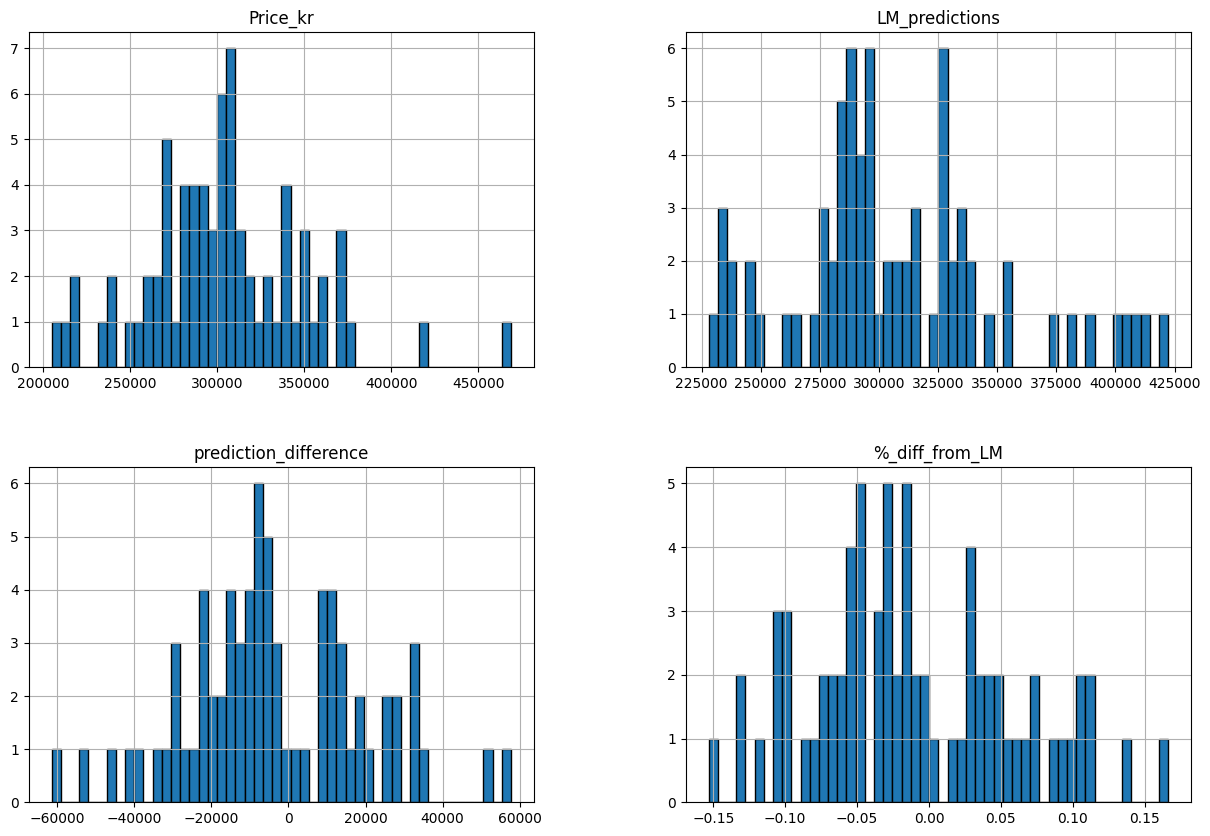

In [44]:
y_test.hist(bins=50, edgecolor='black', figsize=(15, 10))

We decide on the categories

+- 5% are the fair prrice
between 5% and 10% + or -
More than 10% + or -

In [45]:
y_test['price_category'] = y_test['%_diff_from_LM']

In [46]:
y_test

,Price_kr,LM_predictions,prediction_difference,%_diff_from_LM,price_category
272,289900,261754.907643,28145.092357,0.107525,0.107525
332,309900,328132.733637,-18232.733637,-0.055565,-0.055565
468,214900,233893.020056,-18993.020056,-0.081204,-0.081204
98,299000,287816.636646,11183.363354,0.038856,0.038856
437,359800,326734.872883,33065.127117,0.101199,0.101199
...,...,...,...,...,...
152,317000,303666.249095,13333.750905,0.043909,0.043909
412,234900,239263.826497,-4363.826497,-0.018239,-0.018239
330,339900,311481.494388,28418.505612,0.091237,0.091237
154,349700,374693.950295,-24993.950295,-0.066705,-0.066705


In [47]:
bins = [-1, -0.1, -0.05, 0.05, 0.1, 1]
labels = ['Cheap', 'Underpriced', 'Fair priced', 'Overpriced', 'Expensive']

# Create a new categorical variable
y_test['price_category'] = pd.cut(y_test['price_category'], bins=bins, labels=labels, right=False)
y_test['price_category'] = y_test['price_category'].cat.set_categories(labels, ordered=True)

In [48]:
y_test['price_category'].value_counts()

price_category
Fair priced    37
Underpriced    13
Cheap           9
Overpriced      7
Expensive       7
Name: count, dtype: int64

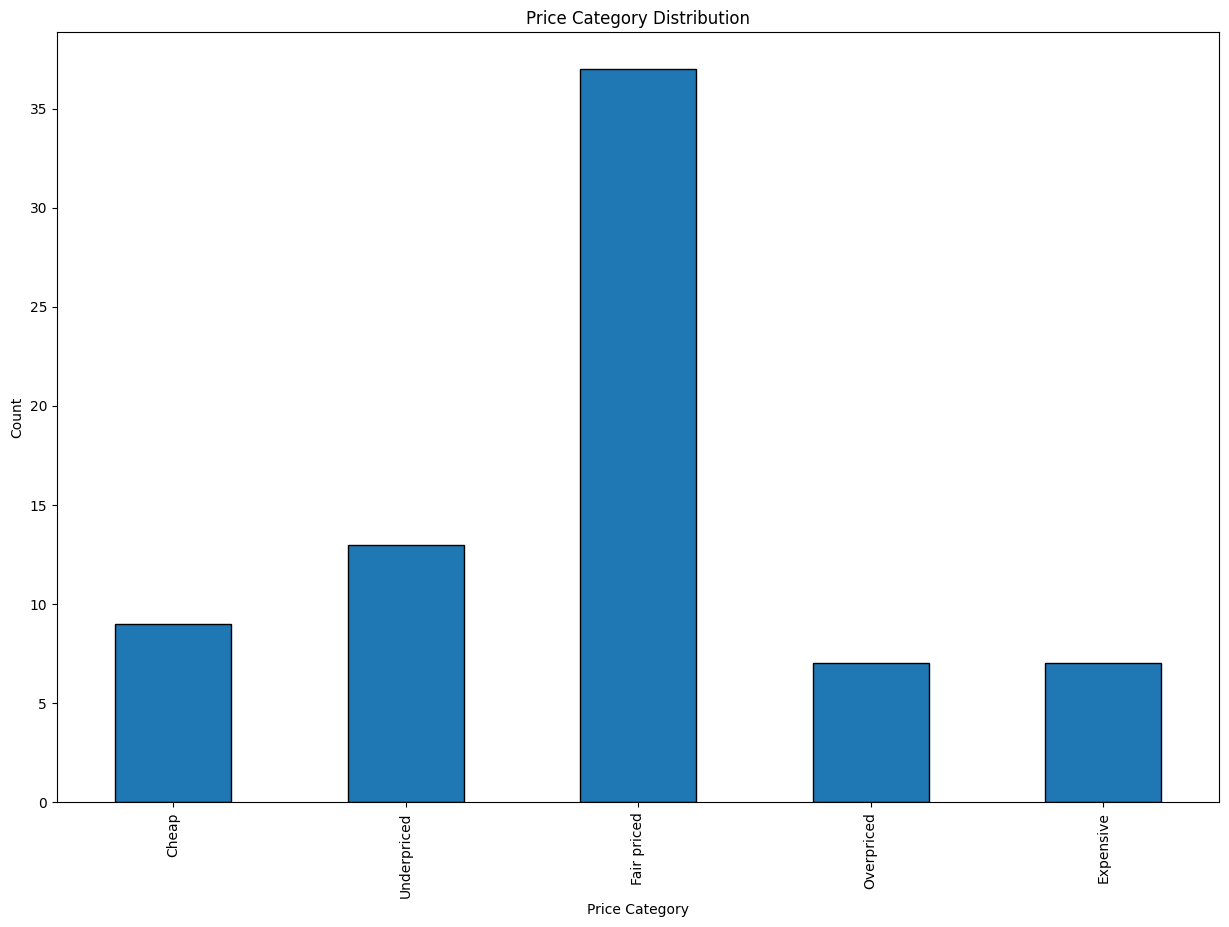

In [49]:
y_test['price_category'].value_counts(sort=False).plot(kind='bar', edgecolor='black', figsize=(15, 10))
plt.title('Price Category Distribution')
plt.xlabel('Price Category')
plt.ylabel('Count')
plt.show()

Importing links to see the specific cars

In [50]:
y_test['Link'] = test_df['Link']

In [52]:
y_test.head

<bound method NDFrame.head of      Price_kr  LM_predictions  prediction_difference  %_diff_from_LM  \
272    289900   261754.907643           28145.092357        0.107525   
332    309900   328132.733637          -18232.733637       -0.055565   
468    214900   233893.020056          -18993.020056       -0.081204   
98     299000   287816.636646           11183.363354        0.038856   
437    359800   326734.872883           33065.127117        0.101199   
..        ...             ...                    ...             ...   
152    317000   303666.249095           13333.750905        0.043909   
412    234900   239263.826497           -4363.826497       -0.018239   
330    339900   311481.494388           28418.505612        0.091237   
154    349700   374693.950295          -24993.950295       -0.066705   
62     468800   411037.433944           57762.566056        0.140529   

    price_category                                               Link  
272      Expensive  https://www.b

In [53]:
y_test.to_csv('C:/Simon/Projekter/Data Science Project/BilbasenProject/data/data_analysis/predictions_categories.csv')